## Perk Preference analysis for ESG Professionals
#### Seowoo Kim
#### Date: 2024-10-16

In [4]:
import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


### 1. Load csv file to SQLite

In [14]:
# load the survey data
import pandas as pd
df = pd.read_csv('/Users/kseowoo/Library/CloudStorage/OneDrive-Personal/resume project data and code/MeOH/perkpreference2.csv')

In [15]:
df.head()

,age,gender,education,occupation,income_level,esg_program_experience,esg_interest,perk_preference
0,20s,male,graduate program,no,medium,no,2,Experience-based reward
1,20s,female,undergrad,no,low,no,5,Experience-based reward
2,30s,male,highschool,yes,low,no,5,Experience-based reward
3,30s,female,graduate program,no,medium,yes,3,Experience-based reward
4,30s,female,highschool,no,low,yes,2,Experience-based reward


In [16]:
# create in-memory SQLite DB
conn = sqlite3.connect(":memory:")
df.to_sql("survey",conn, if_exists="replace",index=False)

67

In [17]:
# perk pereferences by occupation
query = """
select occupation, perk_preference, count(*) as n
from survey
group by occupation, perk_preference
order by occupation, n desc
"""

In [18]:
perk_counts = pd.read_sql(query, conn)
print("Perk counts by occupation (SQL query):\n", perk_counts)

Perk counts by occupation (SQL query):
   occupation             perk_preference   n
0         no     Experience-based reward  16
1         no            Financial reward  15
2         no  Social contribution reward   6
3         no         Eco-friendly reward   4
4        yes            Financial reward  11
5        yes     Experience-based reward   9
6        yes         Eco-friendly reward   6


#### 2. Descriptive Statistics(EDA)

In [37]:
# missing value check

# Count missing values for each column
print("\n--- Missing Values per Column ---")
print(df.isnull().sum())

# Percentage of missing values
print("\n--- Missing Value Percentage ---")
print((df.isnull().sum() / len(df) * 100).round(2))

# Quick check if dataset has any missing at all
if df.isnull().values.any():
    print("\nThere are missing values in the dataset.")
else:
    print("\nNo missing values in the dataset.")


--- Missing Values per Column ---
age                       0
gender                    0
education                 0
occupation                0
income_level              0
esg_program_experience    0
esg_interest              0
perk_preference           0
age_group                 0
dtype: int64

--- Missing Value Percentage ---
age                       0.0
gender                    0.0
education                 0.0
occupation                0.0
income_level              0.0
esg_program_experience    0.0
esg_interest              0.0
perk_preference           0.0
age_group                 0.0
dtype: float64

No missing values in the dataset.


In [23]:
# Count distribution for variables
print("\n--- Descriptive statistics ---")
print("Age distribution:\n", df["age"].value_counts(), "\n")
print("Gender distribution:\n", df["gender"].value_counts(), "\n")
print("Education distribution:\n", df["education"].value_counts(), "\n")
print("Occupation (ESG-related) distribution:\n", df["occupation"].value_counts(), "\n")
print("Income distribution:\n", df["income_level"].value_counts(), "\n")
print("ESG program experience:\n", df["esg_program_experience"].value_counts(), "\n")
print("ESG interest (0–5):\n", df["esg_interest"].value_counts(), "\n")
print("Perk preference:\n", df["perk_preference"].value_counts(), "\n")


--- Descriptive statistics ---
Age distribution:
 age
20s    20
30s    15
40s    15
50s    10
60+     7
Name: count, dtype: int64 

Gender distribution:
 gender
female        33
male          32
non-binary     2
Name: count, dtype: int64 

Education distribution:
 education
undergrad           30
graduate program    22
highschool          15
Name: count, dtype: int64 

Occupation (ESG-related) distribution:
 occupation
no     41
yes    26
Name: count, dtype: int64 

Income distribution:
 income_level
medium    33
low       24
high      10
Name: count, dtype: int64 

ESG program experience:
 esg_program_experience
no     37
yes    30
Name: count, dtype: int64 

ESG interest (0–5):
 esg_interest
3    21
2    16
4    14
1     8
5     7
0     1
Name: count, dtype: int64 

Perk preference:
 perk_preference
Financial reward              26
Experience-based reward       25
Eco-friendly reward           10
Social contribution reward     6
Name: count, dtype: int64 



In [25]:
# Visualizations
sns.set(style="whitegrid")

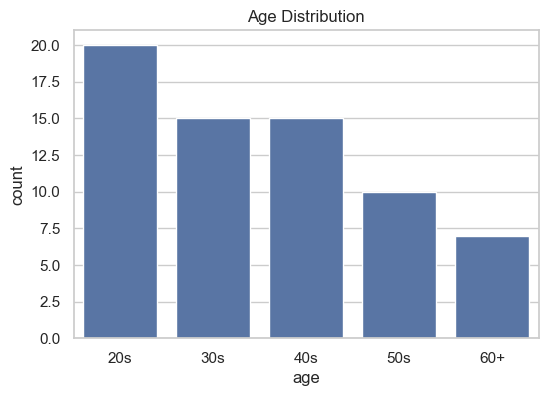

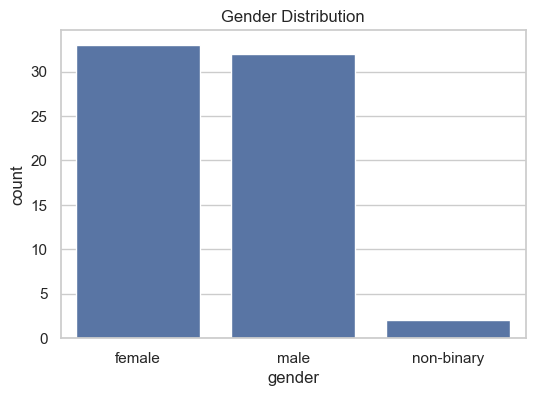

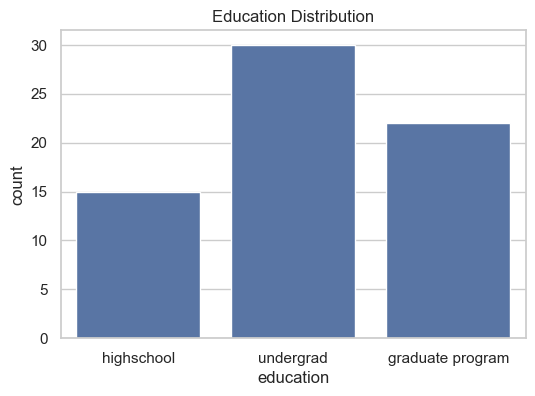

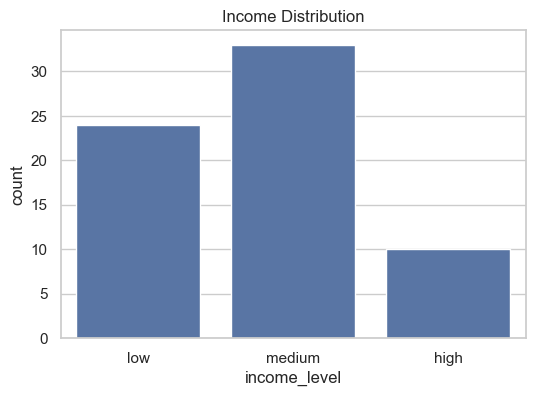

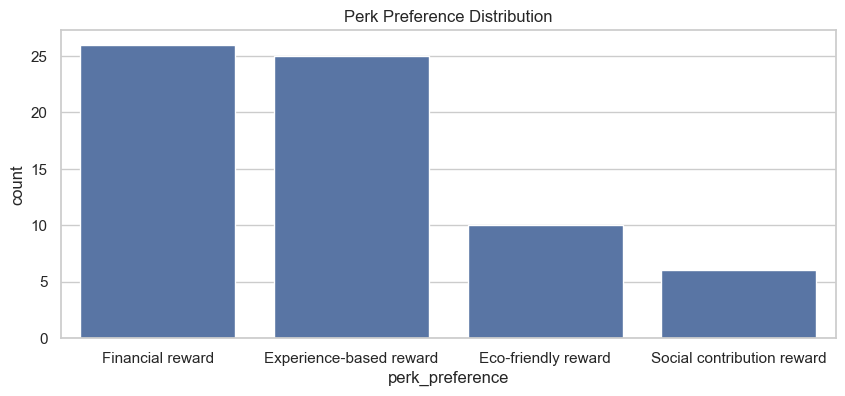

In [31]:
# Age distribution
plt.figure(figsize=(6,4))
sns.countplot(data=df, x="age", order=["20s","30s","40s","50s","60+"])
plt.title("Age Distribution")
plt.show()

# Gender distribution
plt.figure(figsize=(6,4))
sns.countplot(data=df, x="gender", order=df["gender"].value_counts().index)
plt.title("Gender Distribution")
plt.show()

# Education distribution
plt.figure(figsize=(6,4))
sns.countplot(data=df, x="education", order=["highschool","undergrad","graduate program"])
plt.title("Education Distribution")
plt.show()

# Income distribution
plt.figure(figsize=(6,4))
sns.countplot(data=df, x="income_level", order=["low","medium","high"])
plt.title("Income Distribution")
plt.show()

# Perk preference distribution
plt.figure(figsize=(10,4))
sns.countplot(data=df, x="perk_preference", order=["Financial reward","Experience-based reward","Eco-friendly reward","Social contribution reward"])
plt.title("Perk Preference Distribution")
plt.show()


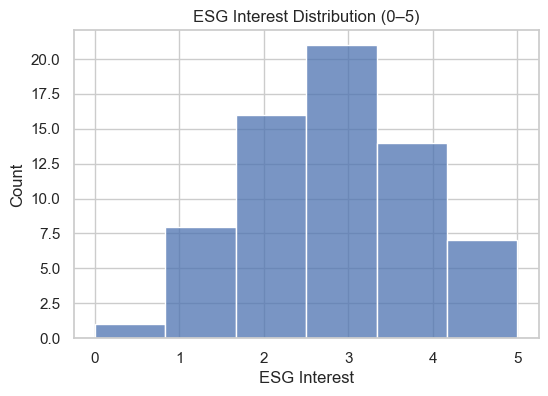

In [32]:
# ESG interest distribution (numeric)
plt.figure(figsize=(6,4))
sns.histplot(df["esg_interest"], bins=6, kde=False)
plt.title("ESG Interest Distribution (0–5)")
plt.xlabel("ESG Interest")
plt.ylabel("Count")
plt.show()

In [39]:
# ESG interest grouping
df["esg_interest_group"] = pd.cut(
    df["esg_interest"],
    bins=[0, 2, 4, 5],               # 경계값
    labels=["Low", "Medium", "High"] # group name
)

In [41]:
# Cross-tabulations
print("\n--- Cross Tabulations ---")

# Age group vs perk preference
df["age_group"] = df["age"].replace({"20s":"Yonger(20s-30s)","30s":"Yonger(20s-30s)","40s":"Older (40s and above)","50s":"Older (40s and above)","60+":"Older (40s and above)"})
crosstab_age_perk = pd.crosstab(df["age_group"], df["perk_preference"])
print("\nAge group vs Perk preference:\n", crosstab_age_perk)

# Gender vs perk preference
crosstab_gender_perk = pd.crosstab(df["gender"], df["perk_preference"])
print("\nGender vs Perk preference:\n", crosstab_gender_perk)

# ESG interest vs perk preference
crosstab_esginterest_perk = pd.crosstab(df["esg_interest_group"], df["perk_preference"])
print("\nESG interest vs Perk preference:\n", crosstab_gender_perk)

# Education vs perk preference
crosstab_edu_perk = pd.crosstab(df["education"], df["perk_preference"])
print("\nEducation vs Perk preference:\n", crosstab_edu_perk)


--- Cross Tabulations ---

Age group vs Perk preference:
 perk_preference        Eco-friendly reward  Experience-based reward  \
age_group                                                             
Older (40s and above)                    6                        8   
Yonger(20s-30s)                          4                       17   

perk_preference        Financial reward  Social contribution reward  
age_group                                                            
Older (40s and above)                16                           2  
Yonger(20s-30s)                      10                           4  

Gender vs Perk preference:
 perk_preference  Eco-friendly reward  Experience-based reward  \
gender                                                          
female                             3                       14   
male                               6                       10   
non-binary                         1                        1   

perk_preference  Fina

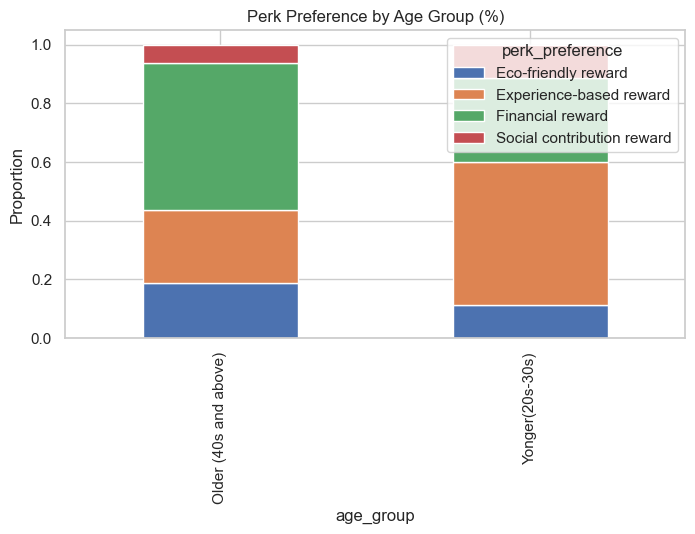

In [42]:
crosstab_age_perk_pct = crosstab_age_perk.div(crosstab_age_perk.sum(axis=1), axis=0)
crosstab_age_perk_pct.plot(kind="bar", stacked=True, figsize=(8,4))
plt.title("Perk Preference by Age Group (%)")
plt.ylabel("Proportion")
plt.show()

### 3. Multinomial Logistic Regression
#### baseline: financial reward

In [49]:
# Ensure outcome categorical order so baseline=Financial reward
y_cat = pd.Categorical(
    df["perk_preference"],
    categories=[
        "Financial reward", #0
        "Experience-based reward", #1
        "Eco-friendly reward", # 2
        "Social contribution reward", #3
    ],
    ordered=True
)
y = y_cat.codes 

In [56]:
# Predictors (one-hot); drop_first to avoid dummy trap
X = pd.get_dummies(
    df[[
        "age_group", "gender", "education", "occupation",
        "income_level", "esg_program_experience", "esg_interest_group"
    ]],
    drop_first=True,
    dtype=float
)
X = sm.add_constant(X, has_constant="add")

In [59]:
# Fit multinomial logistic regression
mn_model = sm.MNLogit(y, X)
mn_res = mn_model.fit(method="newton", maxiter=200, disp=False)

print("\n=== Multinomial Logit Summary (baseline: Financial reward) ===")
print(mn_res.summary())


=== Multinomial Logit Summary (baseline: Financial reward) ===
                          MNLogit Regression Results                          
Dep. Variable:                      y   No. Observations:                   67
Model:                        MNLogit   Df Residuals:                       31
Method:                           MLE   Df Model:                           33
Date:                Sun, 07 Sep 2025   Pseudo R-squ.:                  0.2865
Time:                        00:37:09   Log-Likelihood:                -59.050
converged:                      False   LL-Null:                       -82.756
Covariance Type:            nonrobust   LLR p-value:                   0.04988
                       y=1       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         -0.6555      1.283     -0.511      0.609      -3.170       1.859
age_group_Yonger(20

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [60]:
# Odds ratios (exp coefficients)
or_table = np.exp(mn_res.params)
print("\n--- Odds Ratios (vs baseline = Financial reward) ---")
print(or_table)



--- Odds Ratios (vs baseline = Financial reward) ---
                                       0             1             2
const                       5.191684e-01  4.224693e-01  1.188973e+00
age_group_Yonger(20s-30s)   4.314667e+00  1.012686e+00  1.596488e+00
gender_male                 1.056461e+00  4.200969e+00  5.670133e+00
gender_non-binary           4.823092e+16  3.773942e+17  2.235950e-01
education_highschool        2.096689e+00  2.872040e-01  8.544923e+00
education_undergrad         5.594681e-01  1.663723e-01  2.679908e-01
occupation_yes              6.756838e-01  2.083611e+00  2.053308e-12
income_level_low            5.397511e+00  4.155642e+00  3.839481e-01
income_level_medium         2.025822e+00  1.019076e+00  1.966298e-01
esg_program_experience_yes  2.148942e-01  1.806604e-01  1.563739e-01
esg_interest_group_Medium   6.160129e-01  4.783782e-01  3.470306e-01
esg_interest_group_High     3.859823e+00  1.063632e+01  4.529642e-10


### 4. Chi-square tests
#### Association between categorical predictors and perk preference

In [64]:
from scipy.stats import chi2_contingency

print("\n--- Chi-square Tests ---")

# Age group vs Perk preference
chi2, p, dof, exp = chi2_contingency(crosstab_age_perk)
print("\n[Age group vs Perk preference]")
print(crosstab_age_perk)
print(f"Chi2 = {chi2:.3f}, dof = {dof}, p = {p:.4f}")

# Gender vs Perk preference
chi2, p, dof, exp = chi2_contingency(crosstab_gender_perk)
print("\n[Gender vs Perk preference]")
print(crosstab_gender_perk)
print(f"Chi2 = {chi2:.3f}, dof = {dof}, p = {p:.4f}")

# ESG interest vs Perk preference
chi2, p, dof, exp = chi2_contingency(crosstab_esginterest_perk)
print("\n[ESG interest vs Perk preference]")
print(crosstab_esginterest_perk)
print(f"Chi2 = {chi2:.3f}, dof = {dof}, p = {p:.4f}")

# Education vs Perk preference
chi2, p, dof, exp = chi2_contingency(crosstab_edu_perk)
print("\n[Education vs Perk preference]")
print(crosstab_edu_perk)
print(f"Chi2 = {chi2:.3f}, dof = {dof}, p = {p:.4f}")



--- Chi-square Tests ---

[Age group vs Perk preference]
perk_preference        Eco-friendly reward  Experience-based reward  \
age_group                                                             
Older (40s and above)                    6                        8   
Yonger(20s-30s)                          4                       17   

perk_preference        Financial reward  Social contribution reward  
age_group                                                            
Older (40s and above)                16                           2  
Yonger(20s-30s)                      10                           4  
Chi2 = 5.568, dof = 3, p = 0.1346

[Gender vs Perk preference]
perk_preference  Eco-friendly reward  Experience-based reward  \
gender                                                          
female                             3                       14   
male                               6                       10   
non-binary                         1                  